In [2]:
import numpy as np
from scipy.integrate import odeint

import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib import animation

%matplotlib inline

import pickle
import datetime

In [3]:
class flow(object):
    def __init__(self, nx=256, ny=256, lx=1.0e6, ly=2.0e6, beta=6.0e-10, kappa=100.0, w=4.0e-6):
        x = np.linspace(-np.pi, np.pi, nx, endpoint=False)
        y = np.linspace(-np.pi, np.pi, ny, endpoint=False)
        self.xx, self.yy = np.meshgrid(x,y)
        
        kx = np.fft.rfftfreq(nx, lx/nx)
        ky = np.fft.fftfreq(ny, ly/ny)
        self.kkx, self.kky = np.meshgrid(kx,ky)
        
        self.ksq = self.kkx**2 + self.kky**2
        self.ksq[0,0] += 1.0e-15
        self.kmax = np.min(np.max(kx), np.max(ky))
        
        self.nx = nx
        self.ny = ny
        self.lx = lx
        self.ly = ly
        self.beta = beta
        self.kappa = kappa
        self.w = w
        
        self.psihat = np.zeros((nx,int(ny/2+1)), dtype=complex)
        fzero = 1.0e-4
        thick = 1.0e3
        famp = self.w * fzero/thick
        phases = np.random.uniform(-np.pi, np.pi, size=self.psihat.shape)
        
        forcing = np.zeros_like(self.psihat, dtype=complex)
        forcing[np.abs(self.ksq - self.kmax**2/81) < 3e-11] = famp
        self.forcefield = forcing * (np.cos(phases) + np.sin(phases)*(0.0+1.0j))
        self.psihat += self.forcefield

        self.psi = np.fft.irfft2(self.psihat)
        
        self.qhat = -self.psihat*self.ksq
        self.q = np.fft.irfft2(self.qhat)
        
    def psihatshape(self):
        return self.psihat.shape
    
    def plot_psi(self):
        return plt.contour(2*self.xx, 2*self.yy, self.psi)
        
    def plot_q(self):
        return plt.contour(self.xx, self.yy, self.q)
        
        
    def get_psihat_from_qhat(self, qhat):
        """What it says on the tin.        
        """
        
        psihat = -qhat/self.ksq
        return psihat
        
    def waveterm(self, psihat):
        """Compute the beta wave term.
        
        Assume that we start and end in Fourier space.
        """
        return self.beta*psihat*self.kkx*(0.0+1.0j)
    
    def dissipation(self, qhat):
        """Dissipation term, all in Fourier space."""
        
        return -self.kappa*qhat*self.ksq
    
    def forcing(self, t):
        """Forcing is in the form of random phases in a k-space anulus.
        
        The magnitude (and variables) come from the ocean problem, and probably aren't appropriate for
        atmospheric simulation.
        """
#        fzero = 1.0e-4
#        thick = 1.0e3
#        famp = self.w * fzero/thick

#        phases = np.random.uniform(-np.pi, np.pi, size=self.qhat.shape)        
#        return self.forcefield * (np.cos(phases) + np.sin(phases)*(0.0+1.0j))
        return self.forcefield

    def nlterm(self, qhat, psihat):
        """Compute the jacobian determinant."""
        
        # dealias
        qhat[self.ksq>4/9*self.kmax**2] = 0.0
        psihat[self.ksq>4/9*self.kmax**2] = 0.0
        qhat[0,0] = 0.0
        psihat[0,0] = 0.0
        
        psihat_x = psihat*self.kkx*(0.0+1.0j)
        psihat_y = psihat*self.kky*(0.0+1.0j)
        qhat_x = qhat*self.kkx*(0.0+1.0j)
        qhat_y = qhat*self.kky*(0.0+1.0j)
        
        psi_x = np.fft.irfft2(psihat_x)
        psi_y = np.fft.irfft2(psihat_y)
        q_x = np.fft.irfft2(qhat_x)
        q_y = np.fft.irfft2(qhat_y)
        
        jac = psi_x*q_y - psi_y*q_x
        
        jachat = np.fft.rfft2(jac)
        return jachat
    
    def rhs(self, q_reshaped, t):
        """The time derivative, ready for the integrator."""
        
        qhat = self.unmunge(q_reshaped)
        
        psihat = self.get_psihat_from_qhat(qhat)
        nlterm = self.nlterm(qhat, psihat)
        waveterm = self.waveterm(psihat)
        dissipation = self.dissipation(qhat)
        forcing = self.forcing(t)
        
        return self.munge(forcing + dissipation - waveterm - nlterm)
    
    def munge(self, qhat):
        """format a complex k-space field for odeint"""
        
        r = qhat.real
        i = qhat.imag
        z = np.array([r,i])
        return z.reshape(-1)
    
    def unmunge(self, munged):
        """Return the 1d real sequence to its 2d complex state"""
        
        z = munged.reshape((2,self.nx,int(self.ny/2+1)))
        r = z[0]
        i = z[1]
        return r + (0+1.0j)*i

/opt/anaconda3/lib/python3.5/site-packages/numpy/core/_methods.py:29: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  return umr_minimum(a, axis, None, out, keepdims)


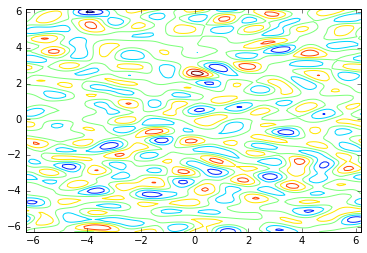

In [4]:
foo = flow(nx = 128, ny=128)
foo.plot_psi()

In [5]:
def mungeany(array):
    r = array.real
    i = array.imag
    z = np.array([r, i])
    return z.reshape(-1)

In [61]:
#linspace, keep all frames
totaldays = 100
day = 1

t0 = np.linspace(0, 86400, 10)
result = odeint(foo.rhs, foo.munge(foo.qhat), t0).tolist()
init = foo.munge(foo.qhat)

while day < totaldays:
    t = np.linspace(day*86400, (day+1)*86400, 10)
    result = result + odeint(foo.rhs, init, t).tolist()
    t0.tolist().append(t.tolist())
    day += 1
t0 = np.array(t0)
result = np.array(result)
result.shape

AttributeError: 'list' object has no attribute 'real'

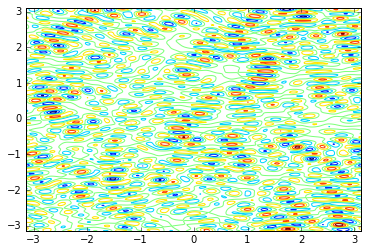

In [53]:
plt.contour(foo.xx, foo.yy, np.fft.irfft2(foo.unmunge(result[99])))

In [8]:
#munge, keep last frame in day
#days = np.linspace(1, 5, 5)
days = np.array(np.linspace(1, 100, 100))
result = np.zeros(16640)
init = foo.munge(foo.qhat)
for day in days:
    t = np.linspace(day*86400, (day+1)*86400, 100)
    integration = odeint(foo.rhs, init, t)
    result = np.vstack([result,integration[-1]])
    init = result[-1]
    with open("results.pkl", "wb") as f:
        pickle.dump(result, f)
    print('Timestamp: {:%Y-%m-%d %H:%M:%S}'.format(datetime.datetime.now()))


Timestamp: 2016-12-03 01:32:59
Timestamp: 2016-12-03 01:42:40
Timestamp: 2016-12-03 01:49:08
Timestamp: 2016-12-03 01:55:34
Timestamp: 2016-12-03 01:55:34
Timestamp: 2016-12-03 01:55:35
Timestamp: 2016-12-03 02:02:02
Timestamp: 2016-12-03 02:08:28
Timestamp: 2016-12-03 02:14:57
Timestamp: 2016-12-03 02:21:25
Timestamp: 2016-12-03 02:27:52
Timestamp: 2016-12-03 02:34:20
Timestamp: 2016-12-03 02:40:48
Timestamp: 2016-12-03 02:47:16
Timestamp: 2016-12-03 02:53:43
Timestamp: 2016-12-03 03:03:24
Timestamp: 2016-12-03 03:09:52
Timestamp: 2016-12-03 03:16:19
Timestamp: 2016-12-03 03:22:47
Timestamp: 2016-12-03 03:29:14
Timestamp: 2016-12-03 03:35:42
Timestamp: 2016-12-03 03:42:10
Timestamp: 2016-12-03 03:48:37
Timestamp: 2016-12-03 03:55:05
Timestamp: 2016-12-03 04:01:32
Timestamp: 2016-12-03 04:07:59
Timestamp: 2016-12-03 04:14:27
Timestamp: 2016-12-03 04:20:54
Timestamp: 2016-12-03 04:27:22
Timestamp: 2016-12-03 04:33:49
Timestamp: 2016-12-03 04:40:16
Timestamp: 2016-12-03 04:46:44
Timestam

In [7]:
result.shape

(21, 16640)

In [77]:
foo.unmunge(result[-1]).shape

(256, 129)

In [9]:
test = pickle.load(open("results.pkl", "rb"))

In [10]:
test.shape

(101, 16640)

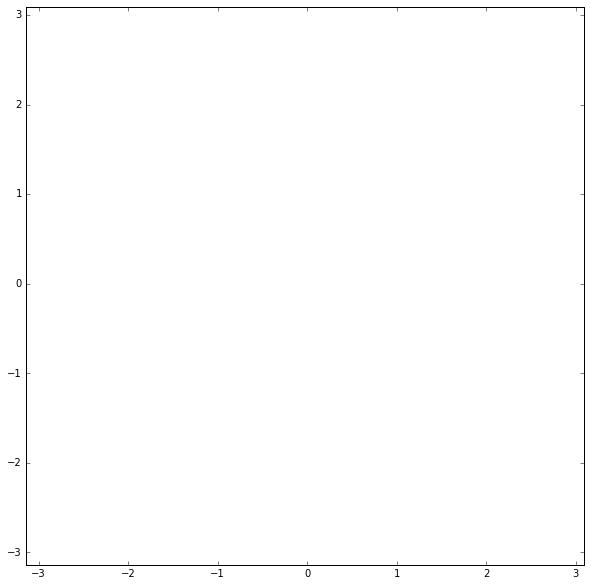

In [11]:
fig = plt.figure(figsize=(10,10))
ax = plt.axes()  
plt.xlabel(r'x')
plt.ylabel(r'y')

totalmax = np.max([np.max(np.abs(np.fft.irfft2(foo.unmunge(frame)))) for frame in result])
levels = np.linspace(-totalmax, totalmax, 10)

# animation function
def animate(i): 
    z = np.fft.irfft2(foo.unmunge(result[i]))
    ax.clear()
    
    cont = plt.contour(foo.xx, foo.yy, z, levels)
    return cont  

anim = animation.FuncAnimation(fig, animate, frames=len(days)+1, blit=False)
mywriter = animation.FFMpegWriter()

anim.save("dayatatime.mp4", writer=mywriter)

In [ ]:
fig = plt.figure(figsize=(10,10))
ax = plt.axes()  
plt.xlabel(r'x')
plt.ylabel(r'y')

totalmax = np.max([np.max(np.abs(foo.unmunge(frame))) for frame in result])
levels = np.linspace(-totalmax, totalmax, 10)

# animation function
def animate(i): 
    z = foo.unmunge(result[i])
    ax.clear()
    
    cont = plt.contour(foo.kkx, foo.kky, z, levels)
    return cont  

anim = animation.FuncAnimation(fig, animate, frames=len(t), blit=False)
mywriter = animation.FFMpegWriter()

anim.save("kspace.mp4", writer=mywriter, fps=45, dpi=100, bitrate=4000)

In [7]:
nx = 256
lx = 1.0e6

help(np.fft.rfftfreq(nx, lx/nx))

Help on ndarray object:

class ndarray(builtins.object)
 |  ndarray(shape, dtype=float, buffer=None, offset=0,
 |          strides=None, order=None)
 |  
 |  An array object represents a multidimensional, homogeneous array
 |  of fixed-size items.  An associated data-type object describes the
 |  format of each element in the array (its byte-order, how many bytes it
 |  occupies in memory, whether it is an integer, a floating point number,
 |  or something else, etc.)
 |  
 |  Arrays should be constructed using `array`, `zeros` or `empty` (refer
 |  to the See Also section below).  The parameters given here refer to
 |  a low-level method (`ndarray(...)`) for instantiating an array.
 |  
 |  For more information, refer to the `numpy` module and examine the
 |  the methods and attributes of an array.
 |  
 |  Parameters
 |  ----------
 |  (for the __new__ method; see Notes below)
 |  
 |  shape : tuple of ints
 |      Shape of created array.
 |  dtype : data-type, optional
 |      Any o

In [20]:
writer = animation.FFMpegWriter()

In [21]:
writer.bin_path()

'ffmpeg'

In [22]:
!ffmpeg -version

ffmpeg version 3.2 Copyright (c) 2000-2016 the FFmpeg developers
built with gcc 4.8 (Ubuntu 4.8.4-2ubuntu1~14.04.3)
configuration: --extra-libs=-ldl --prefix=/opt/ffmpeg --mandir=/usr/share/man --enable-avresample --disable-debug --enable-nonfree --enable-gpl --enable-version3 --enable-libopencore-amrnb --enable-libopencore-amrwb --disable-decoder=amrnb --disable-decoder=amrwb --enable-libpulse --enable-libfreetype --enable-gnutls --enable-libx264 --enable-libx265 --enable-libfdk-aac --enable-libvorbis --enable-libmp3lame --enable-libopus --enable-libvpx --enable-libspeex --enable-libass --enable-avisynth --enable-libsoxr --enable-libxvid --enable-libvidstab --enable-libwavpack --enable-nvenc
libavutil      55. 34.100 / 55. 34.100
libavcodec     57. 64.100 / 57. 64.100
libavformat    57. 56.100 / 57. 56.100
libavdevice    57.  1.100 / 57.  1.100
libavfilter     6. 65.100 /  6. 65.100
libavresample   3.  1.  0 /  3.  1.  0
libswscale      4.  2.100 /  4.  2.100
libswresample   2.  3.100